# Detection Malicious URL Using ML Models
## Context
Malicious URLs or malicious website is a very serious threat to cybersecurity. Malicious URLs host unsolicited content (spam, phishing, drive-by downloads, etc.) and lure unsuspecting users to become victims of scams (monetary loss, theft of private information, and malware installation), and cause losses of billions of dollars every year. We have collected this dataset to include a large number of examples of Malicious URLs so that a machine learning-based model can be developed to identify malicious urls so that we can stop them in advance before infecting computer system or spreading through inteinternet.

A URL consists of the top-level domain, hostname, paths, and port of the web address, as in the following diagram:

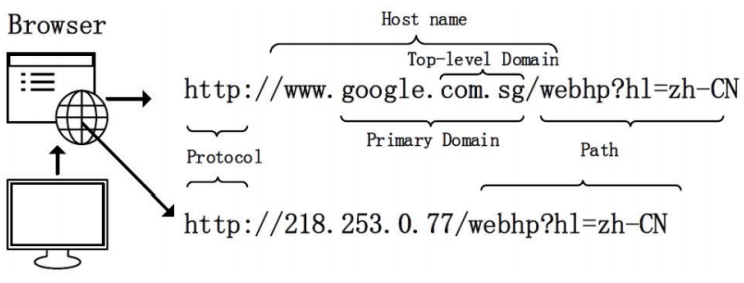

# Installing dependencies

In [1]:
# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install -U datasets --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torch_optimizer numpy torch transformers evaluate python-whois --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install xgboost lightgbm --quiet

Note: you may need to restart the kernel to use updated packages.


# Importing Library

In [5]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Import label encoder
from sklearn import preprocessing, metrics

import itertools
from sklearn.metrics import classification_report, mean_squared_error,confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
import random
import math
from collections import Counter



import os
import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4
import os

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier

In [7]:
pip install --upgrade --force-reinstall pandas

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl.metadata (18 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl.metadata (5.6 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl (10.8 MB)
Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
scikit-image 0.20.0 requires scipy<1.9.2,>=1.8; python_version <= "3.9", but you have scipy 1.10.1 which is incompatible.
spyder 5.2.2 requires pyqt5<5.13, but you have pyqt5 5.15.10 which is incompatible.
spyder 5.2.2 requires pyqtwebengine<5.13, but you have pyqtwebengine 5.15.6 which is incompatible.


In [8]:
%pip install --upgrade pandas "dask[complete]"

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
from lightgbm import LGBMClassifier

# Data Understanding

In [10]:
df = pd.read_csv('malicious_phish.csv')

### Dataset Information

In [11]:
print(df.shape)
print(df.info())

(651191, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None


In [12]:
df.groupby('type').apply(lambda x: x.sample(1)).reset_index(drop=True)

,url,type
0,http://1337x.to/torrent/1110014/Blackhat-2015-...,benign
1,http://www.tagrijn-emma.nl/index.php?option=co...,defacement
2,http://51.255.170.237/Pandora.sh,malware
3,cancelation.apprenew291092.app-renewbopak23092...,phishing


In [13]:
df.isna().sum()

url     0
type    0
dtype: int64

### Data Distribution

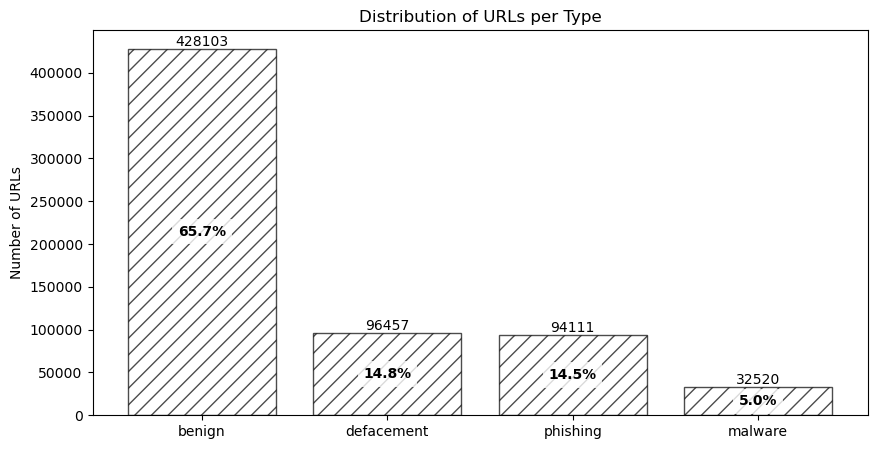

Counter({'benign': 428103, 'defacement': 96457, 'phishing': 94111, 'malware': 32520})


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

types = df['type'].values

counter_types = Counter(types)

type_names = list(counter_types.keys())
type_values = list(counter_types.values())

sorted_indices = np.argsort(type_values)[::-1]
type_names = [type_names[i] for i in sorted_indices]
type_values = [type_values[i] for i in sorted_indices]

total_count = sum(type_values)
percentages = [value / total_count * 100 for value in type_values]

pattern = '//'

y_pos = np.arange(len(type_names))
plt.figure(1, figsize=(10, 5))
bars = plt.bar(y_pos, type_values, align='center', alpha=0.7, color='none', edgecolor='black', hatch=pattern)

for bar, value, percentage in zip(bars, type_values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value}', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), fontweight='bold')

plt.xticks(y_pos, type_names)
plt.ylabel('Number of URLs')
plt.title('Distribution of URLs per Type')
plt.show()

print(counter_types)

In [15]:
df['url_len'] = [len(url) for url in df.url]
df.head()

,url,type,url_len
0,br-icloud.com.br,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235


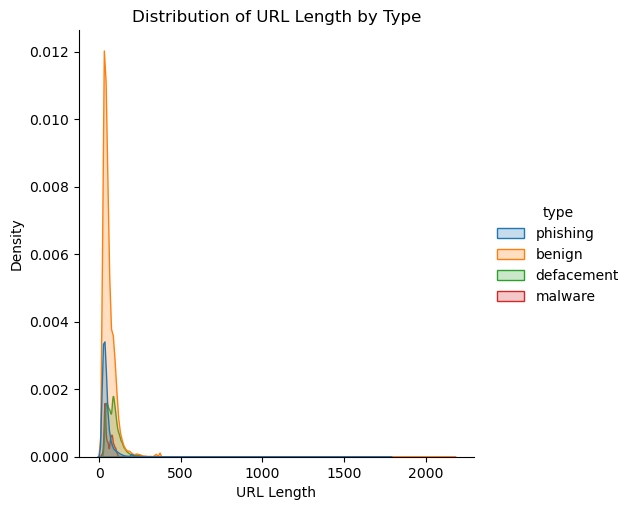

In [16]:
# Plot distribution of 'url_len' for each 'type'
sns.displot(df, x='url_len', hue='type', kind='kde', fill=True)

# Add labels and title
plt.xlabel('URL Length')
plt.ylabel('Density')
plt.title('Distribution of URL Length by Type')
plt.show()

# Data Preparation

## Label Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
le.fit(df["type"])

df["type_code"] = le.transform(df["type"])
df

,url,type,url_len,type_code
0,br-icloud.com.br,phishing,16,3
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,1
...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,39,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,44,3
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,42,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,45,3


In [18]:
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_label_mapping

{'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}

### Splitting
We need to make the data into huggingface dataset pyarrow format, since we gonna upload the dataset into huggingface hub

In [19]:
df = df[['url', 'type', 'type_code']]
dataset = Dataset.from_pandas(df, preserve_index=False)
dataset

Dataset({
    features: ['url', 'type', 'type_code'],
    num_rows: 651191
})

In [20]:
# split train to 80% of total and test to 20% of total
train_test_dataset = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 520952
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 130239
    })
})

In [21]:
# split the validation test to 10% of total and test set to 10% of total
val_test_dataset = train_test_dataset['test'].train_test_split(test_size=0.5, seed=42, shuffle=True)
val_test_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65120
    })
})

In [22]:
from datasets import DatasetDict

# 80% train, 10% validation, 10% test
dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'val': val_test_dataset['train'],
    'test': val_test_dataset['test'],
})
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 520952
    })
    val: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65120
    })
})

# Feature Engineering

In [23]:
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['val'])

## Check IP
To disguise the identity of a website, online criminals frequently use an Internet protocol address instead of the domain name server. This feature will determine if the URL contains an IP address or not

In [24]:
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df_train['use_of_ip'] = df_train['url'].apply(lambda i: having_ip_address(i))
df_test['use_of_ip'] = df_test['url'].apply(lambda i: having_ip_address(i))

df_train

,url,type,type_code,use_of_ip
0,tools.ietf.org/html/rfc1328,phishing,3,0
1,twnty.com/,benign,0,0
2,pianoplus.ca/,benign,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0
...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0


## Abnormal URL
The WHOIS database may be used to extract this feature. Identity is commonly
included in the URL of a trustworthy website

In [25]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df_train['abnormal_url'] = df_train['url'].apply(lambda i: abnormal_url(i))
df_test['abnormal_url'] = df_test['url'].apply(lambda i: abnormal_url(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0
1,twnty.com/,benign,0,0,0
2,pianoplus.ca/,benign,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0
...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1


## Count of dot (.)
The URLs of phishing or malware websites frequently contain more than two subdomains. A dot separates each domain (.). Every URL with more than three dot characters (.)
raises the risk of a malicious website

In [26]:
df_train['count.'] = df_train['url'].apply(lambda i: i.count('.'))
df_test['count.'] = df_test['url'].apply(lambda i: i.count('.'))

df_train.head()

,url,type,type_code,use_of_ip,abnormal_url,count.
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2
1,twnty.com/,benign,0,0,0,1
2,pianoplus.ca/,benign,0,0,0,1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3


## Count of WWW (www.)
The majority of secure websites typically only contain one www in their URLs. If
the URL has no www or more than one www, this feature aids in the detection of fraudulent
websites.

In [27]:
df_train['count-www'] = df_train['url'].apply(lambda i: i.count('www'))
df_test['count-www'] = df_test['url'].apply(lambda i: i.count('www'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0
1,twnty.com/,benign,0,0,0,1,0
2,pianoplus.ca/,benign,0,0,0,1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0
...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0


## Count (@)
If the URL contains the "@" sign, everything before it is ignored

In [28]:
df_train['count@'] = df_train['url'].apply(lambda i: i.count('@'))
df_test['count@'] = df_test['url'].apply(lambda i: i.count('@'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0
1,twnty.com/,benign,0,0,0,1,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0
...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0


## Count Dir / URL Depth
Websites that have several directories in their URLs are typically suspect

In [29]:
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df_train['count_dir'] = df_train['url'].apply(lambda i: no_of_dir(i))
df_test['count_dir'] = df_test['url'].apply(lambda i: no_of_dir(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2
1,twnty.com/,benign,0,0,0,1,0,0,1
2,pianoplus.ca/,benign,0,0,0,1,0,0,1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7
...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2


## Count Embed Domain
Knowing how many embedded domains there are will help you spot
dangerous URLs. You may accomplish it by looking for the character "//" in the URL

In [30]:
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df_train['count_embed_domian'] = df_train['url'].apply(lambda i: no_of_embed(i))
df_test['count_embed_domian'] = df_test['url'].apply(lambda i: no_of_embed(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0


## Count Suspicious URL


In [31]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['sus_url'] = df_train['url'].apply(lambda i: suspicious_words(i))
df_test['sus_url'] = df_test['url'].apply(lambda i: suspicious_words(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0


## Count Shortening URL
This feature tells you whether a URL has been shortened using a service, such as bit.ly,
goo.gl, go2l.ink, etc

In [32]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['short_url'] = df_train['url'].apply(lambda i: shortening_service(i))
df_test['short_url'] = df_test['url'].apply(lambda i: shortening_service(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0


## Count HTTPS
Malicious Websites often avoid using HTTPS protocols since they typically demand
user login information and guarantee that online transactions are secure. Hence, whether HTTPS is
present or not is a key component of the URL.

In [33]:
df_train['count-https'] = df_train['url'].apply(lambda i : i.count('https'))
df_test['count-https'] = df_test['url'].apply(lambda i : i.count('https'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0


## Count HTTP
Safe websites typically have a single HTTP in their URL, but phishing or malicious
websites frequently have several HTTPs.

In [34]:
df_train['count-http'] = df_train['url'].apply(lambda i : i.count('http'))
df_test['count-http'] = df_test['url'].apply(lambda i : i.count('http'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1


## Count (%)
As we all know, spaces are not permitted in URLs. Normal URL encoding substitutes
the symbol (%) for spaces. Secure websites typically have less spaces in their URLs than
dangerous ones, which means that they have more spaces overall.

In [35]:
df_train['count%'] = df_train['url'].apply(lambda i: i.count('%'))
df_test['count%'] = df_test['url'].apply(lambda i: i.count('%'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0


## Count (-)
To make a Website appear legitimate, phishers and other cybercriminals frequently add
dashes (-) to the brand name's prefix or suffix. An illustration. www.flipkart-india.com.

In [36]:
df_train['count-'] = df_train['url'].apply(lambda i: i.count('-'))
df_test['count-'] = df_test['url'].apply(lambda i: i.count('-'))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0


## Count (=)
The equal sign (=) in the URL denotes that variables are being sent from one form page
to another. As anybody may alter the values in a URL to change the page, it is regarded as being
riskier

In [37]:
df_train['count='] = df_train['url'].apply(lambda i: i.count('='))
df_test['count='] = df_test['url'].apply(lambda i: i.count('='))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1


## URL Length
To conceal the domain name, attackers frequently utilize lengthy URLs. We
discovered that a safe URL typically has a length of 74 characters

In [38]:
df_train['url_length'] = df_train['url'].apply(lambda i: len(str(i)))
df_test['url_length'] = df_test['url'].apply(lambda i: len(str(i)))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123


## Hostname Length
The hostname's length is a crucial element in identifying fraudulent URLs

In [39]:
df_train['hostname_length'] = df_train['url'].apply(lambda i: len(urlparse(i).netloc))
df_test['hostname_length'] = df_test['url'].apply(lambda i: len(urlparse(i).netloc))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length,hostname_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68,19
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100,7
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123,12


In [40]:
!pip install tld


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## First Directory Length
With this feature, you may figure out how long the URL's first directory
is. In order to get the first directory length of the URL, check for the initial '/' and count the length
of the URL up to this point. Installing the Python TLD library is required to obtain directory-level
information. You may install TLD by visiting this page

In [41]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df_train['fd_length'] = df_train['url'].apply(lambda i: fd_length(i))
df_test['fd_length'] = df_test['url'].apply(lambda i: fd_length(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length,hostname_length,fd_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27,0,4
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68,19,18
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80,0,4
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100,7,8
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46,0,3
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123,12,7


## TLD Length
one of the domains at the top of the Internet's hierarchical domain
name system is a top-level domain (TLD). For instance, the top-level domain is com in the domain
name www.example.com. So, the length of the TLD is crucial for recognizing fraudulent URLs.
since.com is the most common extension for URLs. TLDs encompassing.

In [42]:
#Length of Top Level Domain
df_train['tld'] = df_train['url'].apply(lambda i: get_tld(i,fail_silently=True))
df_test['tld'] = df_test['url'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df_train['tld_length'] = df_train['tld'].apply(lambda i: tld_length(i))
df_test['tld_length'] = df_test['tld'].apply(lambda i: tld_length(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-https,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,0,27,0,4,None,-1
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,0,10,0,0,None,-1
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,0,13,0,0,None,-1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,0,1,0,3,0,68,19,18,dk,2
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,0,55,0,4,None,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,0,7,0,80,0,4,None,-1
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,0,1,0,12,0,100,7,8,com,3
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,0,6,0,46,0,3,None,-1
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,0,1,0,0,1,123,12,7,net,3


## Digit Count
Suspicious URLs are often those that contain numbers. Counting the amount of
digits in a URL is a key characteristic for identifying fraudulent URLs because safe URLs often
do not include digits

In [43]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df_train['count-digits']= df_train['url'].apply(lambda i: digit_count(i))
df_test['count-digits']= df_test['url'].apply(lambda i: digit_count(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length,count-digits
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,None,-1,4
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,None,-1,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,None,-1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,dk,2,9
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,None,-1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,7,0,80,0,4,None,-1,10
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,1,0,12,0,100,7,8,com,3,6
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,6,0,46,0,3,None,-1,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,1,0,0,1,123,12,7,net,3,33


## Letter Count
Another important factor in recognizing fraudulent URLs is the number of letters
in the URL. Attackers typically accomplish this by adding more letters and numbers to the URL in
an effort to lengthen it and conceal the domain name.

In [44]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df_train['count-letters']= df_train['url'].apply(lambda i: letter_count(i))
df_test['count-letters']= df_test['url'].apply(lambda i: letter_count(i))
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,27,0,4,None,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,10,0,0,None,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,13,0,0,None,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,0,3,0,68,19,18,dk,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,55,0,4,None,-1,8,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,7,0,80,0,4,None,-1,10,57
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,0,12,0,100,7,8,com,3,6,75
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,6,0,46,0,3,None,-1,0,37
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,0,0,1,123,12,7,net,3,33,74


In [45]:
df_train = df_train.drop("tld",axis=1)
df_test = df_test.drop("tld",axis=1)
df_train

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,-1,8,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,7,0,80,0,4,-1,10,57
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,1,0,12,0,100,7,8,3,6,75
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,6,0,46,0,3,-1,0,37
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,1,0,0,1,123,12,7,3,33,74


In [46]:
df_train.head()

,url,type,type_code,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,-1,8,37


In [47]:
df_train.rename(columns={'type_code': 'labels'}, inplace=True)

In [48]:
df_test.rename(columns={'type_code': 'labels'}, inplace=True)

# Data Splitting

In [49]:
#Predictor Variables
X_train = df_train[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y_train = df_train['labels']

In [50]:
#Predictor Variables
X_test = df_test[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y_test = df_test['labels']

In [51]:
X_train.to_csv('./x-train.csv')
y_train.to_csv('./y-train.csv')
X_test.to_csv('./x-test.csv')
y_test.to_csv('./y-test.csv')

# Modeling

In [52]:
eval_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-macro', 'F1-micro', 'F1-weighted'])
eval_df

,Model,Accuracy,F1-macro,F1-micro,F1-weighted


## LGBM

In [53]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5,
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)

y_predLGB = LGB_C.predict(X_test)
print(classification_report(y_test,y_predLGB))

score = metrics.accuracy_score(y_test, y_predLGB)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 20
[LightGBM] [Info] Start training from score -0.419982
[LightGBM] [Info] Start training from score -1.909440
[LightGBM] [Info] Start training from score -2.995947
[LightGBM] [Info] Start training from score -1.932479
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42951
           1       0.96      0.99      0.98      9557
           2       0.97      0.91      0.94      3253
           3       0.90      0.83      0.87      9359

    accuracy     

In [54]:
lgbm_acc = accuracy_score(y_test, y_predLGB)
lgbm_acc

0.9607186732186732

In [55]:
lgbm_f1_macro = f1_score(y_test, y_predLGB, average='macro')
lgbm_f1_macro

0.9404328018006989

In [56]:
lgbm_f1_micro = f1_score(y_test, y_predLGB, average='micro')
lgbm_f1_micro

0.9607186732186732

In [57]:
lgbm_f1_w = f1_score(y_test, y_predLGB, average='weighted')
lgbm_f1_w

0.9600167936712016

In [58]:
new_eval = {'Model': 'LGBM','Accuracy': lgbm_acc, 'F1-macro': lgbm_f1_macro, 'F1-micro': lgbm_f1_micro, 'F1-weighted': lgbm_f1_w }
eval_df.loc[len(eval_df)] = new_eval

In [59]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


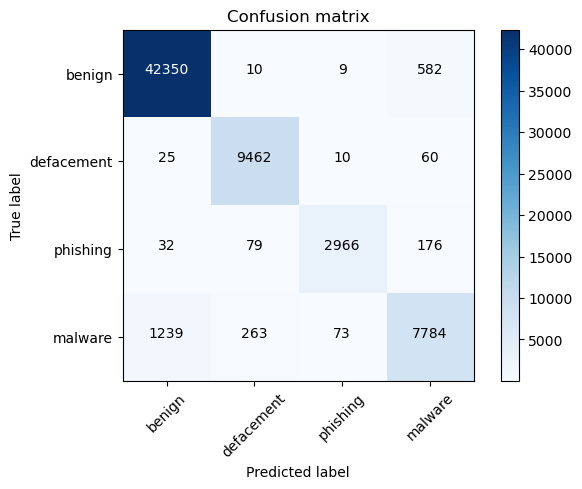

In [60]:
cm = metrics.confusion_matrix(y_test, y_predLGB, labels=[0,1,2,3])
plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize

def evaluate_model(model, X_train, y_train, X_test, y_test, class_names, param_name=None, param_values=None):
    """
    Function to evaluate a classification model and generate:
    1. ROC Curve
    2. Evaluation Metrics (Accuracy, Precision, Recall, F1-score) + Bar Chart
    3. Ablation Plot (if parameter name & values are given)
    
    Parameters:
    - model: Trained classifier
    - X_train, y_train, X_test, y_test: Train-test datasets
    - class_names: List of class labels
    - param_name: Hyperparameter to test (optional for ablation study)
    - param_values: Values of hyperparameter to test (optional for ablation study)
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    
    # 1. **Plot ROC Curve**
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))  # Convert labels to binary
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # 2. **Compute Evaluation Metrics**
    metrics_dict = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_pred, average='weighted'),
    }
    
    # Print metrics
    print("\nEvaluation Metrics:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.4f}")
    
    # **Plot Evaluation Metrics**
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(metrics_dict.keys()), y=list(metrics_dict.values()), palette='Blues_r')
    plt.ylim(0, 1)  # Limit y-axis between 0 and 1
    plt.xlabel("Metrics")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.grid(axis='y')
    plt.show()

    # 3. **Ablation Study Plot** (if parameter name & values are given)
    if param_name and param_values:
        acc_list = []
        for param in param_values:
            # Create a new model instance with the given parameter
            model.set_params(**{param_name: param})
            model.fit(X_train, y_train)
            y_pred_param = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred_param)
            acc_list.append(acc)

        # Plot Ablation Study
        plt.figure(figsize=(8, 6))
        plt.plot(param_values, acc_list, marker='o', linestyle='-', color='b')
        plt.xlabel(param_name)
        plt.ylabel('Accuracy')
        plt.title(f'Ablation Study: Effect of {param_name} on Accuracy')
        plt.grid(True)
        plt.show()
    
    return metrics_dict

In [63]:
class_names = ['benign', 'defacement', 'phishing', 'malware']

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent


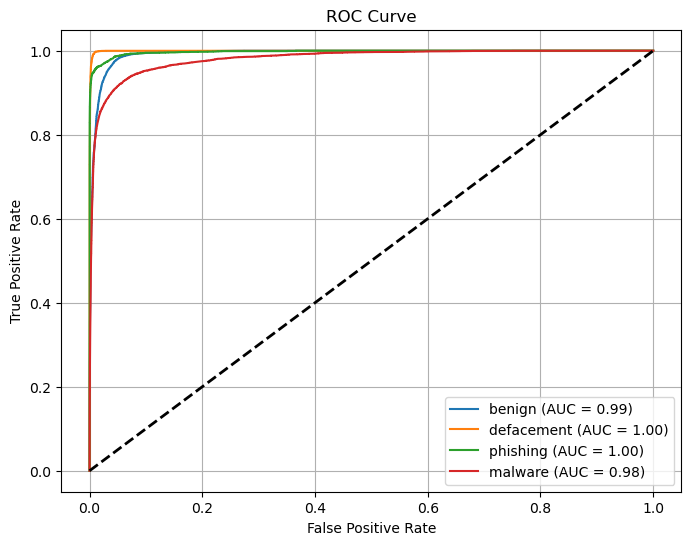


Evaluation Metrics:
Accuracy: 0.9607
Precision: 0.9600
Recall: 0.9607
F1-score: 0.9600


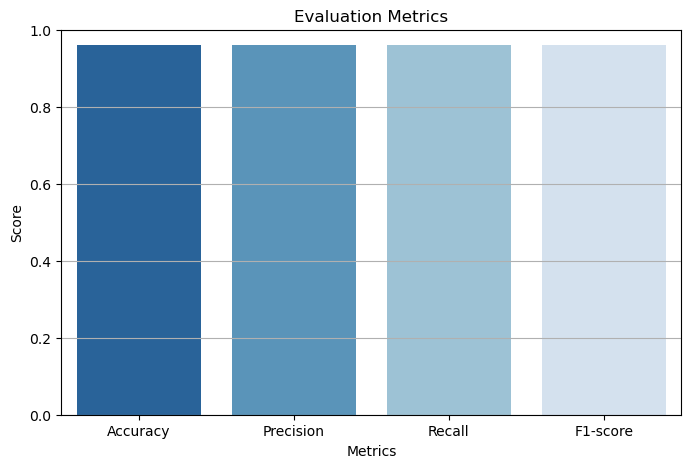

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 20
[LightGBM] [Info] Start training from score -0.419982
[LightGBM] [Info] Start training from score -1.909440
[LightGBM] [Info] Start training from score -2.995947
[LightGBM] [Info] Start training from score -1.932479
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you 

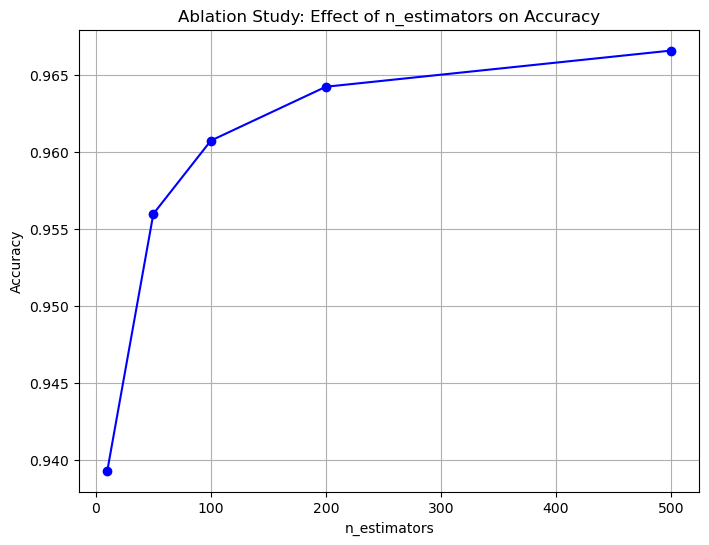

In [64]:
eval_results = evaluate_model(
    model=lgb, 
    X_train=X_train, y_train=y_train, 
    X_test=X_test, y_test=y_test, 
    class_names=class_names,
    param_name="n_estimators", 
    param_values=[10, 50, 100, 200, 500]  # Test different number of trees
)

In [65]:
lgb_feature = lgb.feature_importances_
lgb_feature

array([  88,  305, 4539, 1934,  196, 5060,  121,  679,  695,  439,  827,
       3318, 1967, 7488, 7207,  828, 9078, 2514, 6086, 6631])

In [66]:
lgb_features = lgb_feature.tolist()

## XGBoost

In [67]:
xgb = xgb.XGBClassifier(n_estimators= 100)
xgb.fit(X_train,y_train)
y_predXGB = xgb.predict(X_test)
print(classification_report(y_test,y_predXGB))


score = metrics.accuracy_score(y_test, y_predXGB)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42951
           1       0.97      0.99      0.98      9557
           2       0.98      0.93      0.95      3253
           3       0.92      0.84      0.87      9359

    accuracy                           0.96     65120
   macro avg       0.96      0.94      0.95     65120
weighted avg       0.96      0.96      0.96     65120

accuracy:   0.964


In [68]:
xgb_acc = accuracy_score(y_test, y_predXGB)
xgb_acc

0.9637285012285012

In [69]:
xgb_f1_macro = f1_score(y_test, y_predXGB, average='macro')
xgb_f1_macro

0.9473674935890884

In [70]:
xgb_f1_micro = f1_score(y_test, y_predXGB, average='micro')
xgb_f1_micro

0.9637285012285012

In [71]:
xgb_f1_w = f1_score(y_test, y_predXGB, average='weighted')
xgb_f1_w

0.9630420244049551

In [72]:
new_eval = {'Model': 'XGB','Accuracy': xgb_acc, 'F1-macro': xgb_f1_macro, 'F1-micro': xgb_f1_micro, 'F1-weighted': xgb_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


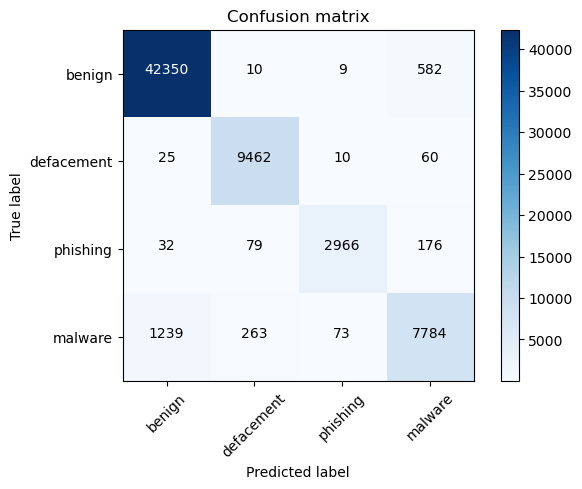

In [73]:
CM=confusion_matrix(y_test,y_predXGB,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

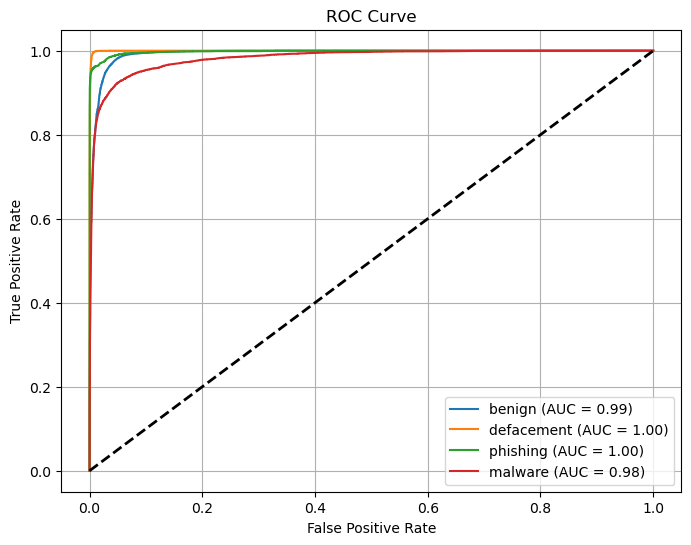


Evaluation Metrics:
Accuracy: 0.9637
Precision: 0.9631
Recall: 0.9637
F1-score: 0.9630


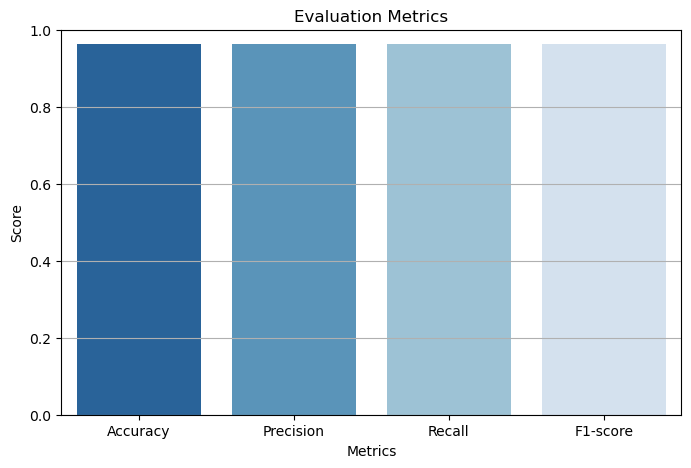

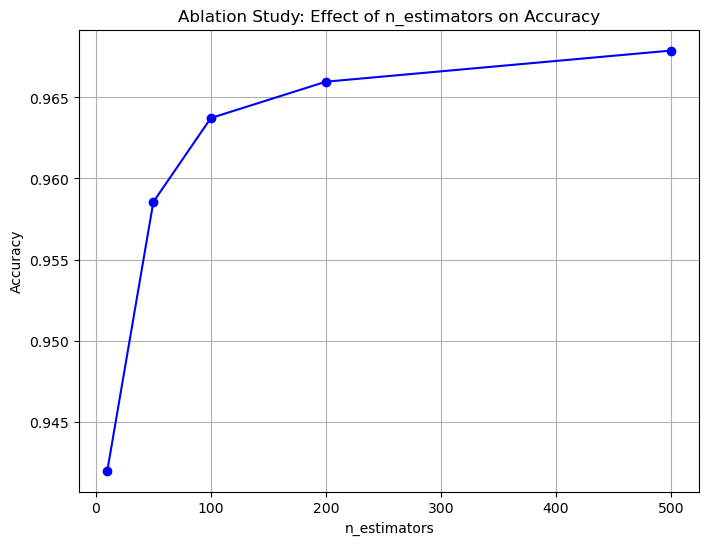

In [74]:
eval_results = evaluate_model(
    model=xgb, 
    X_train=X_train, y_train=y_train, 
    X_test=X_test, y_test=y_test, 
    class_names=class_names,
    param_name="n_estimators", 
    param_values=[10, 50, 100, 200, 500]  # Test different number of trees
)

In [75]:
xgb_feature = xgb.feature_importances_
xgb_features = xgb_feature.tolist()

## Gradient Boosting

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbdt.fit(X_train,y_train)
y_predGBDT = gbdt.predict(X_test)
print(classification_report(y_test,y_predGBDT))

score = metrics.accuracy_score(y_test, y_predGBDT)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     42951
           1       0.90      0.97      0.93      9557
           2       0.93      0.79      0.85      3253
           3       0.88      0.75      0.81      9359

    accuracy                           0.94     65120
   macro avg       0.92      0.87      0.89     65120
weighted avg       0.94      0.94      0.94     65120

accuracy:   0.938


In [77]:
gbdt_acc = accuracy_score(y_test, y_predGBDT)
gbdt_acc

0.9383138820638821

In [78]:
gbdt_f1_macro = f1_score(y_test, y_predGBDT, average='macro')
gbdt_f1_macro

0.8919053180226546

In [79]:
gbdt_f1_micro = f1_score(y_test, y_predGBDT, average='micro')
gbdt_f1_micro

0.9383138820638821

In [80]:
gbdt_f1_w = f1_score(y_test, y_predGBDT, average='weighted')
gbdt_f1_w

0.936326976109249

In [81]:
new_eval = {'Model': 'GBDT','Accuracy': gbdt_acc, 'F1-macro': gbdt_f1_macro, 'F1-micro': gbdt_f1_micro, 'F1-weighted': gbdt_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


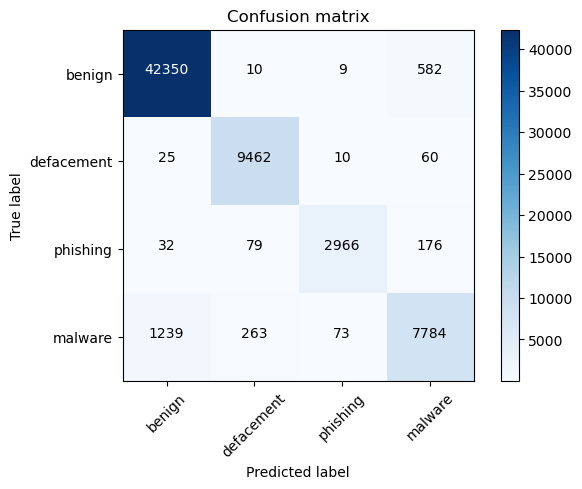

In [82]:
CM=confusion_matrix(y_test,y_predGBDT,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

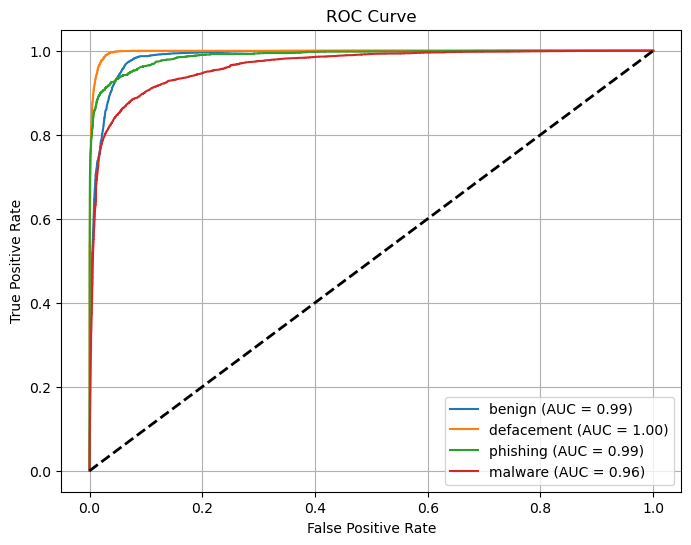


Evaluation Metrics:
Accuracy: 0.9383
Precision: 0.9371
Recall: 0.9383
F1-score: 0.9363


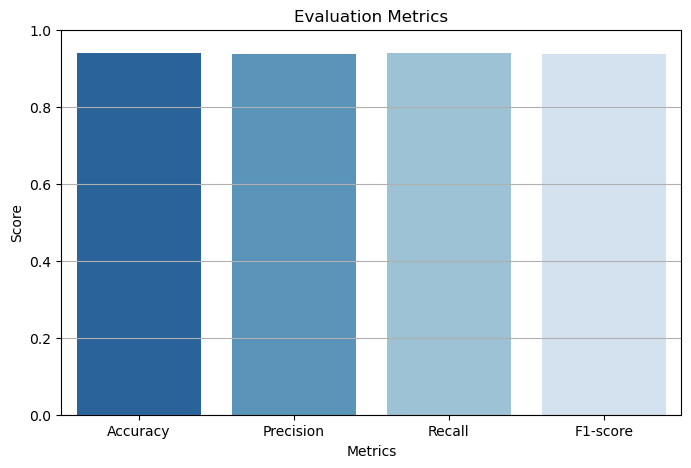

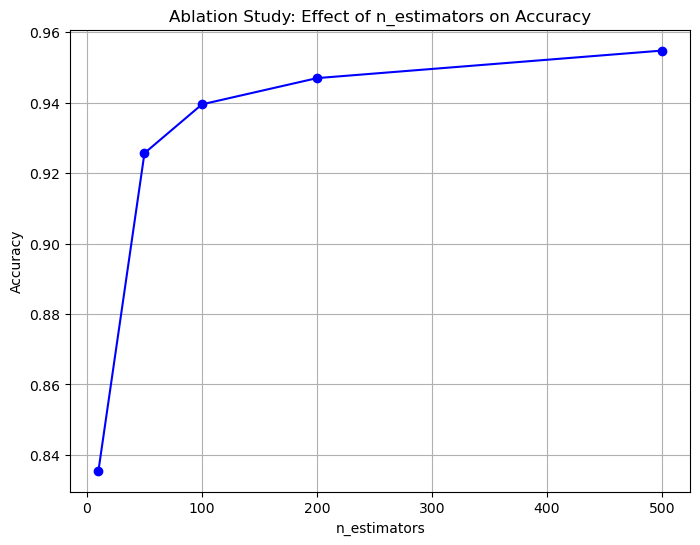

In [83]:
eval_results = evaluate_model(
    model=gbdt, 
    X_train=X_train, y_train=y_train, 
    X_test=X_test, y_test=y_test, 
    class_names=class_names,
    param_name="n_estimators", 
    param_values=[10, 50, 100, 200, 500]  # Test different number of trees
)

In [84]:
gbdt_feature = gbdt.feature_importances_
gbdt_features = gbdt_feature.tolist()

## Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_predRF = rf.predict(X_test)
print(classification_report(y_test,y_predRF))

score = metrics.accuracy_score(y_test, y_predRF)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42951
           1       0.98      1.00      0.99      9557
           2       0.99      0.95      0.97      3253
           3       0.91      0.86      0.89      9359

    accuracy                           0.97     65120
   macro avg       0.96      0.95      0.96     65120
weighted avg       0.97      0.97      0.97     65120

accuracy:   0.967


In [86]:
rf_acc = accuracy_score(y_test, y_predRF)
rf_acc

0.9672604422604423

In [87]:
rf_f1_macro = f1_score(y_test, y_predRF, average='macro')
rf_f1_macro

0.9553948907852596

In [88]:
rf_f1_micro = f1_score(y_test, y_predRF, average='micro')
rf_f1_micro

0.9672604422604423

In [89]:
rf_f1_w = f1_score(y_test, y_predRF, average='weighted')
rf_f1_w

0.9669046339843859

In [90]:
new_eval = {'Model': 'RF','Accuracy': rf_acc, 'F1-macro': rf_f1_macro, 'F1-micro': rf_f1_micro, 'F1-weighted': rf_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


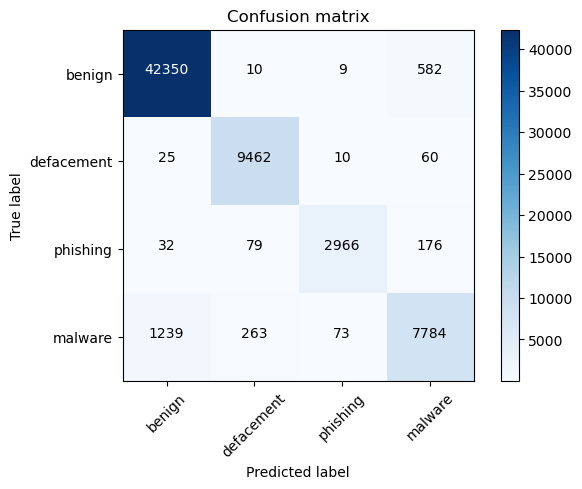

In [91]:
CM=confusion_matrix(y_test,y_predRF,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

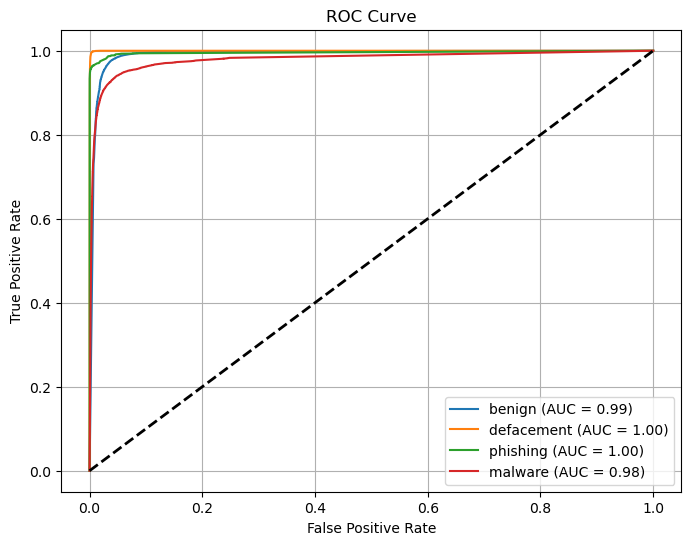


Evaluation Metrics:
Accuracy: 0.9673
Precision: 0.9668
Recall: 0.9673
F1-score: 0.9669


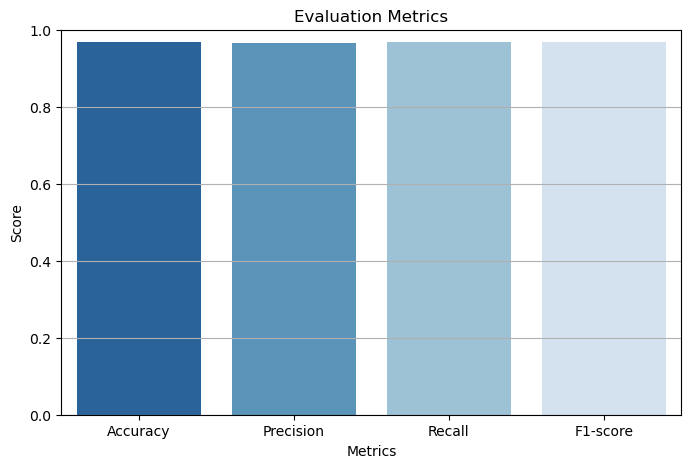

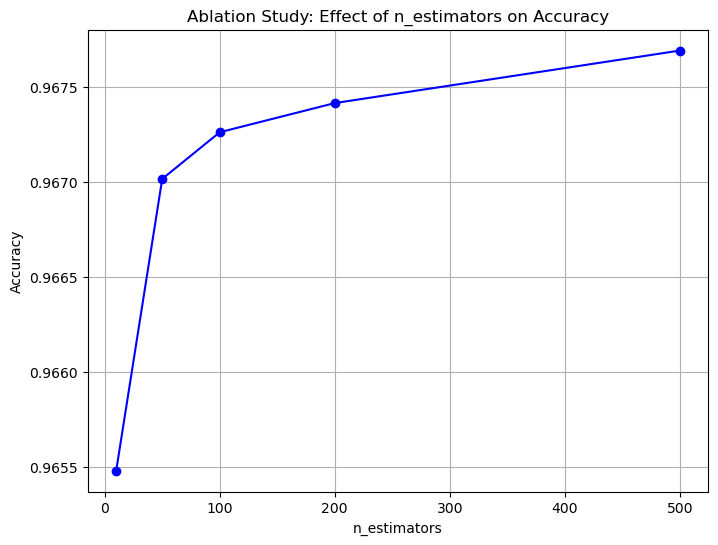

In [92]:
eval_results = evaluate_model(
    model=rf, 
    X_train=X_train, y_train=y_train, 
    X_test=X_test, y_test=y_test, 
    class_names=class_names,
    param_name="n_estimators", 
    param_values=[10, 50, 100, 200, 500]  # Test different number of trees
)

# Plotting Feature Importances

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_importance(feature_dataframe, X_test):
    """
    Plots the top 20 most important features.

    Parameters:
    - feature_dataframe: DataFrame containing feature names and their importance values.
    - X_test: Test set to extract feature names.

    """
    # Ensure 'Feature' and 'mean' columns exist
    if 'mean' not in feature_dataframe.columns:
        raise ValueError("The 'feature_dataframe' must have a 'mean' column for feature importance values.")
    
    tmp = pd.DataFrame({
        'Feature': X_test.columns, 
        'Feature Importance': feature_dataframe['mean'].values
    })

    # Sort by importance & select top 20 features
    tmp = tmp.sort_values(by='Feature Importance', ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10, 12))
    plt.title('Top 20 Feature Importances', fontsize=14)
    sns.barplot(y='Feature', x='Feature Importance', data=tmp, orient='h', palette="viridis")

    # Formatting
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Feature")
    plt.grid(axis='x')
    plt.show()

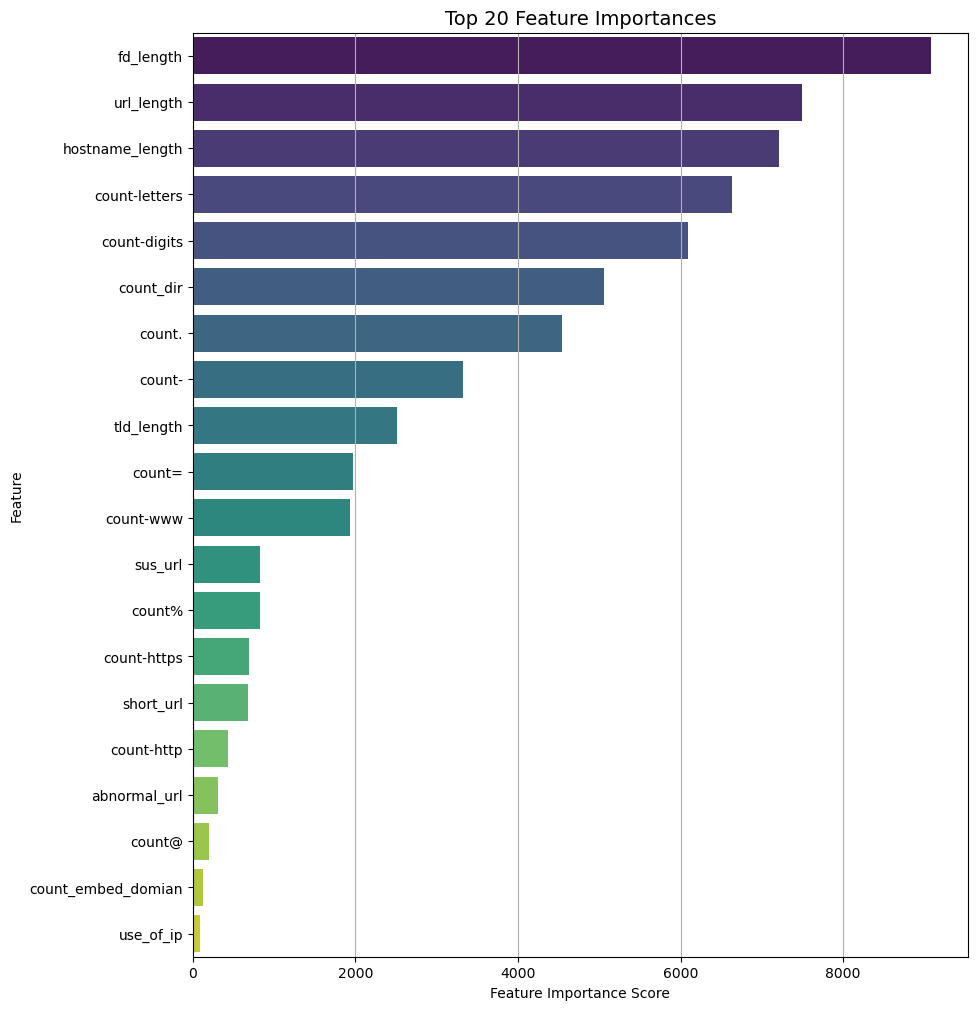

In [97]:
import pandas as pd

# Extract feature importance for LightGBM
feature_importance = LGB_C.feature_importances_

# Create feature importance dataframe
feature_dataframe = pd.DataFrame({
    'Feature': X_train.columns,
    'mean': feature_importance
})

# Now call the function
plot_feature_importance(feature_dataframe, X_test)


# Final Result

In [99]:
eval_df.sort_values(by=['F1-weighted','Accuracy'], ascending=False)

,Model,Accuracy,F1-macro,F1-micro,F1-weighted
3,RF,0.967260,0.955395,0.967260,0.966905
1,XGB,0.963729,0.947367,0.963729,0.963042
0,LGBM,0.960719,0.940433,0.960719,0.960017
2,GBDT,0.938314,0.891905,0.938314,0.936327


<Figure size 1000x500 with 0 Axes>

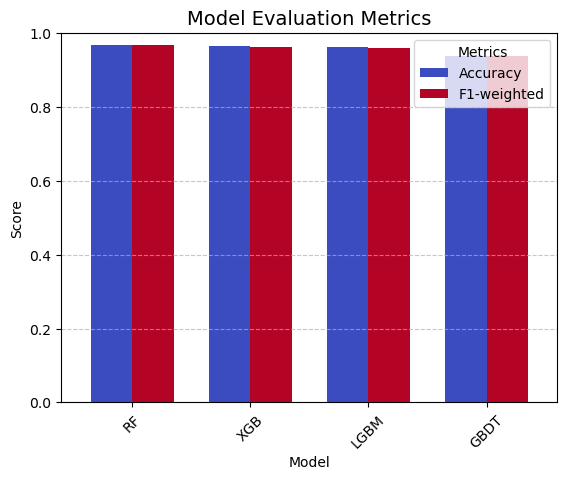

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample Evaluation DataFrame (Ensure you have this structured correctly)
# eval_df = pd.DataFrame({
#     "Model": ["LightGBM", "RandomForest", "XGBoost", "SVM"],
#     "Accuracy": [0.89, 0.85, 0.87, 0.82],
#     "Precision-weighted": [0.88, 0.83, 0.86, 0.80],
#     "Recall-weighted": [0.89, 0.84, 0.86, 0.81],
#     "F1-weighted": [0.88, 0.84, 0.86, 0.80]
# })

# Sort the DataFrame by F1-score and Accuracy
eval_df = eval_df.sort_values(by=['F1-weighted', 'Accuracy'], ascending=False)

# Check available columns
valid_columns = ["Accuracy", "Precision-weighted", "Recall-weighted", "F1-weighted"]
existing_columns = [col for col in valid_columns if col in eval_df.columns]

# Plot Evaluation Metrics
plt.figure(figsize=(10, 5))
eval_df.set_index("Model")[existing_columns].plot(kind='bar', colormap='coolwarm', width=0.7)

# Formatting
plt.title("Model Evaluation Metrics", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.show()

# Conclusion
The evaluation results indicate that the Random Forest (RF) model achieved the highest accuracy (96.73%) and F1-weighted score (96.69%), making it the best-performing model in this comparison. XGBoost (XGB) and LightGBM (LGBM) also performed competitively, with slight differences in their scores. However, GBDT lagged behind, showing lower F1-macro and F1-weighted scores, suggesting it may not generalize as well across all classes.

Overall, RF proves to be the most effective model for this dataset, but further optimization and hyperparameter tuning might help improve the other models' performance. 🚀